## Imports

In [1]:
import numpy as np
import pickle
import os
from MyDataset import MyDataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.nn import functional as F
from tqdm.auto import tqdm
# from PIL import Image
%matplotlib inline

## Transform raw data

In [2]:
pre_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    #transforms.RandomCrop(200),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

## Load Data

In [3]:
train_dataset = MyDataset("./train",pre_transform)
val_dataset = MyDataset("./validate",val_transform)

In [4]:
print("train data length: %d  valid data length % d"%(len(train_dataset),len(val_dataset)))

1754

## Visualize Traning Data

In [ ]:
img,label = train_dataset[0]
if (label == 0):
  print("This is class nil")
elif (label == 1):
  print("This is class MOD")
else:
  print("This is class SEV")

Band8 = img[0][:][:]
Band12 = img[1][:][:]
Band13 = img[2][:][:]
Band14 = img[3][:][:]
Band = [Band8,Band12,Band13,Band14]

for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(Band[i-1])
plt.show()

In [ ]:
#Calculate the number of samples in differnet class
train_nil_count = 0   ##591
train_MOD_count = 0   ##839
train_SEV_count = 0   ##324
valid_nil_count = 0   ##192
valid_MOD_count = 0   ##81
valid_SEV_count = 0   ##33

for i in range (0,1754):
    #print(i)
    img, label = train_dataset[i]
    if (label == 0):
        train_nil_count += 1
    elif (label == 1):
        train_MOD_count += 1
    else:
        train_SEV_count += 1
print("train set has %d nil, %d MOD, %d SEV" %(train_nil_count, train_MOD_count, train_SEV_count))

for i in range (0,306):
    #print(i)
    img, label = val_dataset[i]
    if (label == 0):
        valid_nil_count += 1
    elif (label == 1):
        valid_MOD_count += 1
    else:
        valid_SEV_count += 1
print("valid set has %d nil, %d MOD, %d SEV" %(valid_nil_count, valid_MOD_count, valid_SEV_count))

## Define Model & Loss

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, 3, 1, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.fc1 = nn.Linear(100352, 128)
        self.fc2 = nn.Linear(128, 3)
    
    def forward(self, x):
        # x's shape = N * 4 * 224 * 224, where N is batch size
        x = self.conv1(x)
        # x's shape = N * 16 * 224 * 224
        x = F.relu(x)
        # x's shape = N * 16 * 224 * 224
        x = F.max_pool2d(x, 2)
        # x's shape = N * 16 * 112 * 112
        x = self.conv2(x)
        # x's shape = N * 32 * 112 * 112
        x = F.relu(x)
        # x's shape = N * 32 * 112 * 112
        x = F.max_pool2d(x, 2)
        # x's shape = N * 32 * 56 * 56
        x = torch.flatten(x, 1) # flat starts from the second dim
        # x's shape = N * (32 * 56 * 56) = N * 100352
        x = self.fc1(x)
        # x's shape =  N * 128
        x = F.relu(x)
        # x's shape =  N * 128
        x = self.fc2(x)
        # x's shape =  N * 3
        # output = F.log_softmax(x, dim=1)  # sometimes this is included in criterion
        return x

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=False)

In [7]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [8]:
criterion = nn.CrossEntropyLoss()

In [9]:
def compute_acc(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=True)
    return preds.eq(targets.view_as(preds)).sum().item() / targets.shape[0]

In [10]:
def performance_eval(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=False)
    targets = targets.view_as(preds)
    performance_dict = {"NIL":0.0,"MOD":0.0, "SEV":0.0 }
    for i in range(3):
        TP = targets[preds.eq(i)].eq(i).sum().item()
        FP = (~targets[preds.eq(i)].eq(i)).sum().item()
        FN = (~preds[targets.eq(i)].eq(i)).sum().item()
        Precision =  torch.true_divide(TP,(TP + FP))
        Recall = torch.true_divide(TP,(TP + FN))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        performance_dict[list(performance_dict.keys())[i]] = torch.tensor([Precision,Recall,F1])
    return performance_dict

In [11]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.TP = torch.tensor([0,0,0])
        self.FP = torch.tensor([0,0,0])
        self.FN = torch.tensor([0,0,0])
        
    def update(self, val, outputs, targets, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = preds.view(-1)
        targets = targets.view(-1)
        for i in range(3):
            self.TP[i] += targets[preds.eq(i)].eq(i).sum().item()
            self.FP[i] += (~targets[preds.eq(i)].eq(i)).sum().item()
            self.FN[i] += (~preds[targets.eq(i)].eq(i)).sum().item()

In [12]:
model = model.cuda()
criterion = criterion.cuda()

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
def train_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(train_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
        
    return accs

In [15]:
model.train()
history_acc = []
for epoch in tqdm(range(10)):
    accs = train_one_epoch()
    print("epoch {} acc: {} ".format(epoch, accs.avg))
    class_names = ["NIL","MOD","SEV"]
    for i in range(3):
        Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
        Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        print("class {} Precision {} Recall{} F1 {}".format(class_names[i],Precision,Recall,F1))
    history_acc.append(accs)

epoch 0 acc: 0.5034207525655644 
class NIL Precision 0.5660377144813538 Recall0.25380709767341614 F1 0.3504672646522522
class MOD Precision 0.5094736814498901 Recall0.865315854549408 F1 0.6413427591323853
class SEV Precision 0.109375 Recall0.021604938432574272 F1 0.036082472652196884


epoch 1 acc: 0.5553021664766249 
class NIL Precision 0.9927007555961609 Recall0.23011843860149384 F1 0.37362638115882874
class MOD Precision 0.518243670463562 Recall0.9988080859184265 F1 0.682410478591919
class SEV Precision nan Recall0.0 F1 nan


epoch 2 acc: 0.5553021664766249 
class NIL Precision 0.9856114983558655 Recall0.23181049525737762 F1 0.375342458486557
class MOD Precision 0.5182662606239319 Recall0.9976162314414978 F1 0.6821516156196594
class SEV Precision nan Recall0.0 F1 nan


epoch 3 acc: 0.556442417331813 
class NIL Precision 0.9659863710403442 Recall0.240270733833313 F1 0.38482385873794556
class MOD Precision 0.5189794898033142 Recall0.9940405488014221 F1 0.6819297075271606
class SEV Precision nan Recall0.0 F1 nan


epoch 4 acc: 0.5621436716077537 
class NIL Precision 0.8950276374816895 Recall0.27411168813705444 F1 0.4196891188621521
class MOD Precision 0.5238397717475891 Recall0.9821215867996216 F1 0.683250367641449
class SEV Precision nan Recall0.0 F1 nan


epoch 5 acc: 0.5575826681870011 
class NIL Precision 0.9664429426193237 Recall0.24365481734275818 F1 0.3891891539096832
class MOD Precision 0.5196261405944824 Recall0.9940405488014221 F1 0.6824877262115479
class SEV Precision nan Recall0.0 F1 nan


epoch 6 acc: 0.5610034207525656 
class NIL Precision 0.8888888955116272 Recall0.27072757482528687 F1 0.4150453805923462
class MOD Precision 0.5235069990158081 Recall0.9821215867996216 F1 0.6829672455787659
class SEV Precision nan Recall0.0 F1 nan


epoch 7 acc: 0.5592930444697833 
class NIL Precision 0.9151515364646912 Recall0.2554991543292999 F1 0.39947089552879333
class MOD Precision 0.5223410725593567 Recall0.989272952079773 F1 0.6836901903152466
class SEV Precision nan Recall0.0 F1 nan


epoch 8 acc: 0.5610034207525656 
class NIL Precision 0.9931972622871399 Recall0.24703891575336456 F1 0.3956639766693115
class MOD Precision 0.5214685797691345 Recall0.9988080859184265 F1 0.6852003335952759
class SEV Precision nan Recall0.0 F1 nan


epoch 9 acc: 0.5672748004561003 
class NIL Precision 0.9583333134651184 Recall0.27241963148117065 F1 0.42424243688583374
class MOD Precision 0.5258511900901794 Recall0.9940405488014221 F1 0.6878350377082825
class SEV Precision nan Recall0.0 F1 nan



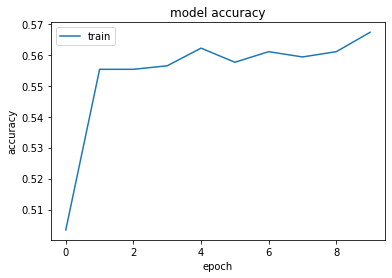

In [16]:
accuracy = []
for accs in history_acc:
    accuracy.append(accs.avg)
plt.plot(range(10),accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [17]:
model.eval()
for X, y in tqdm(val_loader, leave=False):
    inputs = X.cuda()
    outputs = model(inputs)
    print("y actual:",y)
    print(outputs.argmax(dim=1, keepdim=True))
    acc = compute_acc(outputs.cpu(), y)
    print(f'Test Acc: {acc}')

y actual: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 2, 1, 0, 0, 1])
tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
      

In [49]:
img, label = train_dataset.__getitem__(1700)

In [51]:
img

tensor([[[0.6549, 0.6510, 0.6510,  ..., 0.6314, 0.5765, 0.5765],
         [0.6510, 0.6510, 0.6510,  ..., 0.5882, 0.5765, 0.5765],
         [0.6196, 0.6196, 0.6196,  ..., 0.5765, 0.5765, 0.5765],
         ...,
         [0.4863, 0.4980, 0.5020,  ..., 0.5608, 0.5608, 0.5412],
         [0.4941, 0.5020, 0.5059,  ..., 0.5608, 0.5608, 0.5412],
         [0.5216, 0.5333, 0.5333,  ..., 0.5608, 0.5608, 0.5412]],

        [[0.5490, 0.5294, 0.5255,  ..., 0.5412, 0.4941, 0.4941],
         [0.5294, 0.5255, 0.5255,  ..., 0.4980, 0.4941, 0.4941],
         [0.4980, 0.4980, 0.4980,  ..., 0.4941, 0.4941, 0.4941],
         ...,
         [0.5333, 0.5647, 0.5686,  ..., 0.6039, 0.6000, 0.5882],
         [0.5608, 0.5804, 0.5843,  ..., 0.6039, 0.6000, 0.5882],
         [0.6745, 0.6471, 0.6431,  ..., 0.6039, 0.6000, 0.5882]],

        [[0.5490, 0.5294, 0.5255,  ..., 0.5412, 0.4941, 0.4941],
         [0.5294, 0.5255, 0.5255,  ..., 0.4980, 0.4941, 0.4941],
         [0.4980, 0.4980, 0.4980,  ..., 0.4941, 0.4941, 0.

In [42]:
with open("train/severe_HS_H08_20180124_0400_33.98652512_104.272.npy.pickle", 'rb') as f:
    color_img = pickle.load(f)

In [44]:
img = torch.tensor(color_img)
img = img.permute(1,2,0)
img = img/255
img.shape

torch.Size([224, 224, 4])

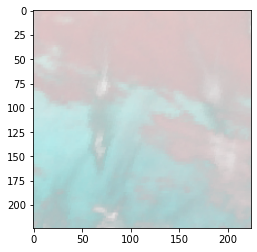

In [53]:
plt.imshow(img.permute(1,2,0))